# Ground Truth problems

These are problems for which the data generating process is a known model, 

$$ y = \phi^*(\mathbf{x}, \theta^*) $$

We assess how well symbolic regression algorithms find the form of the model, $\phi^*$, with some leniency on $\theta^*$ (we allow the model to be off by a constant or a scalar). 

In [2]:
from tabulate import tabulate
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import os
sns.set(font_scale=1.2)
rdir = '../results/'
# figdir = 'figs/ground-truth/'
figdir = '../../paper/figs/results_sym_data/'

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', dpi=400, bbox_inches='tight')


figdir: ../../paper/figs/results_sym_data/


# read data from feather

In [3]:
df_results = pd.read_feather(rdir+'/ground-truth_results.feather')

# compute symbolic solutions

In [4]:
df_results.loc[:,'symbolic_solution'] = df_results[['symbolic_error_is_zero',
                                                    'symbolic_error_is_constant',
                                                    'symbolic_fraction_is_constant']
                                                   ].apply(any,raw=True, axis=1)
# clean up any corner cases (constant models, failures)
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~df_results['simplified_symbolic_model'].isna()
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == '0')
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == 'nan')

# save results for detailed tabulating
df_results.to_feather(rdir+'ground-truth_solns.feather')

## summarize results by dataset, including ranking

In [5]:
df_results2 = df_results.merge(df_results.groupby(['dataset','target_noise'])['algorithm'].nunique().reset_index(),
                              on=['dataset','target_noise'],suffixes=('','_count'))
# count repeat trials
df_results2 = df_results2.merge(
           df_results2.groupby(['algorithm','dataset','target_noise'])['random_state'].nunique().reset_index(),
           on=['algorithm','dataset','target_noise'],suffixes=('','_repeats'))

# accuracy-based exact solutions
df_results2['accuracy_solution'] = df_results2['r2_test'].apply(lambda x: x > 0.999).astype(float)

# get mean solution rates for algs on datasets at specific noise levels, averaged over trials
for soln in ['accuracy_solution','symbolic_solution']:
    df_results2 = df_results2.merge(
        df_results2.groupby(['algorithm','dataset','target_noise'])[soln].mean().reset_index(),
                                  on=['algorithm','dataset', 'target_noise'],suffixes=('','_rate'))

# # # rankings
# for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
#     ascending = 'r2' not in col
#     df_results2[col+'_rank_per_trial']=df_results2.groupby(
#                         ['dataset','target_noise','random_state'])[col].apply(
#                                                                               lambda x:
#                                                                               round(x,3).rank(
#                                                                               ascending=ascending).astype(int))
# # rankings
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
  ascending = 'r2' not in col
  df_results2[col+'_rank_per_trial'] = df_results2.groupby(
                      ['dataset','target_noise','random_state'])[col].transform(
                          lambda x: round(x,3).rank(ascending=ascending).astype(int)
                      )

df_sum = df_results2.groupby(['algorithm','dataset','target_noise','data_group'],as_index=False).median(numeric_only=True)
# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if any([c.endswith(n) for n in ['test','size','rate']])]:
    ascending = 'r2' not in col and 'solution' not in col
    df_sum[col+'_rank'] = df_sum.groupby(['dataset','target_noise'])[col].transform(
        lambda x: round(x,3).rank(ascending=ascending).astype(int))
    df_sum[col+'_norm'] = df_sum.groupby(['dataset','target_noise'])[col].transform(
        lambda x: (x-x.min())/(x.max()-x.min()))
for soln in ['accuracy_solution','symbolic_solution']:
    df_sum[soln +'_rate_(%)'] = df_sum[soln+'_rate'].apply(lambda x: x*100)
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2
df_sum

/home/sca63/.conda/envs/meta_sr/lib/python3.10/site-packages/pandas/core/internals/blocks.py:1986: RuntimeWarning: overflow encountered in multiply
  values = self.values.round(decimals)  # type: ignore[union-attr]


,algorithm,dataset,target_noise,data_group,random_state,process_time,training time (s),feature_noise,model_size,mse_train,...,r2_zero_test_rank,r2_zero_test_norm,accuracy_solution_rate_rank,accuracy_solution_rate_norm,symbolic_solution_rate_rank,symbolic_solution_rate_norm,accuracy_solution_rate_(%),symbolic_solution_rate_(%),rmse_test,log_mse_test
0,AFP,feynman_III_10_19,0.000,Feynman,16322.5,3933.001081,3939.400296,0.0,56.5,5.849199e-01,...,10,0.763299,10,0.000000,8,0.0,0.0,0.0,0.763010,4.588062e-01
1,AFP,feynman_III_10_19,0.001,Feynman,16322.5,3836.068982,3838.458160,0.0,43.0,6.091393e-01,...,12,0.764983,12,0.000000,8,0.0,0.0,0.0,0.782349,4.775190e-01
2,AFP,feynman_III_10_19,0.010,Feynman,16322.5,3997.451181,4004.179745,0.0,60.0,4.277725e-01,...,10,0.832813,11,0.000000,7,NaN,0.0,0.0,0.631359,3.354819e-01
3,AFP,feynman_III_10_19,0.100,Feynman,16322.5,3246.291704,3248.871595,0.0,48.5,3.938359e+00,...,9,0.987881,10,0.000000,7,NaN,0.0,0.0,0.805633,5.001957e-01
4,AFP,feynman_III_12_43,0.000,Feynman,16322.5,762.994263,764.613111,0.0,13.5,2.105290e-07,...,6,0.999991,5,1.000000,6,0.5,100.0,50.0,0.000459,2.109261e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7265,gplearn,strogatz_vdp1,0.100,Strogatz,16322.5,1041.010437,1041.791482,0.0,55.5,2.894002e-01,...,9,0.874341,11,0.000000,7,NaN,0.0,0.0,0.664724,3.659322e-01
7266,gplearn,strogatz_vdp2,0.000,Strogatz,16322.5,803.576279,804.068661,0.0,4.0,1.047183e-06,...,6,0.998957,10,0.857143,3,1.0,87.5,100.0,0.000978,9.557428e-07
7267,gplearn,strogatz_vdp2,0.001,Strogatz,16322.5,787.524314,788.384568,0.0,4.0,1.048401e-06,...,6,0.998968,10,0.800000,1,1.0,80.0,100.0,0.000978,9.557428e-07
7268,gplearn,strogatz_vdp2,0.010,Strogatz,16322.5,768.643139,769.767922,0.0,4.0,2.087898e-06,...,6,0.999002,11,0.800000,1,1.0,80.0,100.0,0.000978,9.557428e-07


# save summary data
used for statistical comparisons

In [7]:
df_sum.to_csv(rdir+'/symbolic_dataset_results_sum.csv.gz',compression='gzip', index=False)

# solution rates by alg/dataset/noise

In [8]:
df_sum.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].mean().round(2).unstack().transpose()

target_noise,0.000,0.001,0.010,0.100
algorithm,,,,
AFP,20.48,19.00,16.31,12.15
AFP_FE,26.23,21.23,20.00,12.31
AIFeynman,52.65,31.89,12.61,0.86
BSR,2.31,0.62,0.08,0.00
DSR,19.71,19.15,18.92,16.62
EPLEX,12.02,9.54,8.23,9.31
FEAT,0.10,0.00,0.00,0.00
FFX,0.00,0.00,0.00,0.08
GP-GOMEA,27.12,10.62,4.69,1.46


# plot comparisons

In [9]:
sns.set_style('whitegrid')
def compare(df_compare=None, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[], est=np.mean,
            orient='h', hue=None, **kwargs):
    df_compare = df_compare.copy()
    if row==None and col == None:
        aspect=1
    else:
        aspect=0.55
#     plt.figure(figsize=(8,7))
    tmp = df_compare.groupby(['target_noise',y])[x].apply(est).unstack().mean()
    order = tmp.sort_values(ascending=False).index

    for c in [x,y,row,col]:
        if c:
            df_compare = df_compare.rename(columns={c:c.replace('_',' ').title()})

    x = x.replace('_',' ').title()
    y = y.replace('_',' ').title()
    if row:
        row = row.replace('_',' ').title()
    if col:
        col = col.replace('_',' ').title()

    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    if orient=='v':
        tmp = x
        x = y
        y = tmp
    if col and not row:
        col_wrap = min(4, df_compare[col].nunique())
    else:
        col_wrap=None

    cat_args = dict(
                data=df_compare,
                kind='point',
                y=y,
                x=x,
                order=order,
                row=row,
                col=col,
                col_wrap=col_wrap,
                palette='flare_r',
                margin_titles=True,
                aspect=aspect,
                hue=hue,
                legend_out=False,
    )
    cat_args.update(kwargs)
    g = sns.catplot( **cat_args )
    if hue:
        g._legend.remove() #(title=hue.replace('_',' ').title())
        g.axes.flat[-1].legend(title=hue.replace('_',' ').title(),
                               fontsize=10
                              )
    for ax in g.axes.flat:
        ax.yaxis.grid(True)
        ax.set_ylabel('')
        ax.set_xlabel(ax.get_xlabel().replace('Symbolic ',''))
        if col:
            ttl = ax.get_title()
            ax.set_title(ttl.replace(col,'').replace('=',''))


    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)

    sns.despine(left=True, bottom=True)
    savename = '-'.join(['cat-'+cat_args['kind']+'plot',x+ '-by-'+ y])
    if row: savename += '_'+row
    if col: savename += '_'+col

    save(g, savename )

/tmp/ipykernel_2814874/3476379285.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot( **cat_args )


saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm.pdf


/tmp/ipykernel_2814874/3476379285.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot( **cat_args )


saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Data-Group.pdf


/tmp/ipykernel_2814874/3476379285.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot( **cat_args )


saving cat-pointplot-R2-Test-by-Algorithm.pdf


/tmp/ipykernel_2814874/3476379285.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot( **cat_args )


saving cat-pointplot-R2-Test-by-Algorithm_Data-Group.pdf


/tmp/ipykernel_2814874/3476379285.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot( **cat_args )


saving cat-pointplot-Accuracy-Solution-by-Algorithm.pdf


/tmp/ipykernel_2814874/3476379285.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot( **cat_args )


saving cat-pointplot-Accuracy-Solution-by-Algorithm_Data-Group.pdf


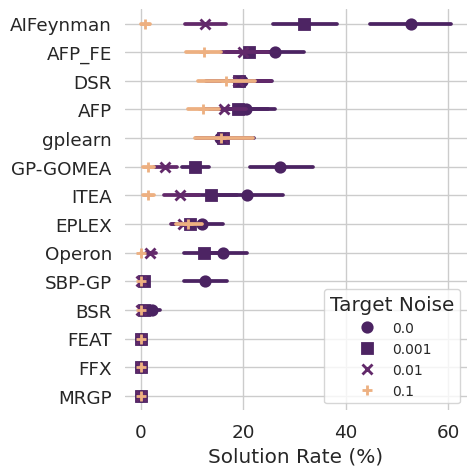

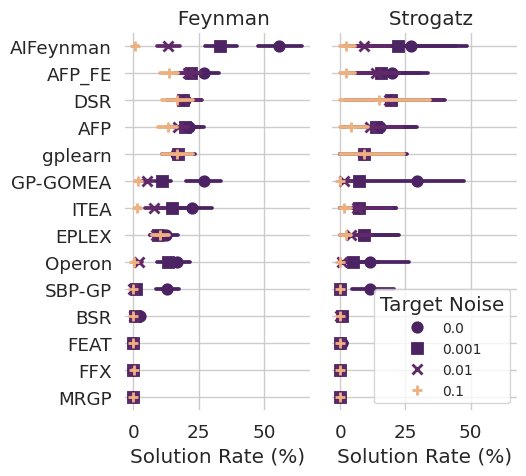

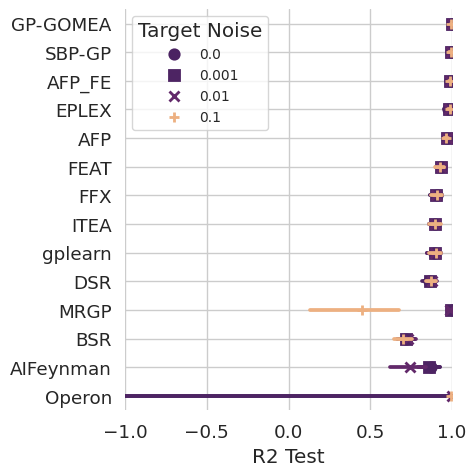

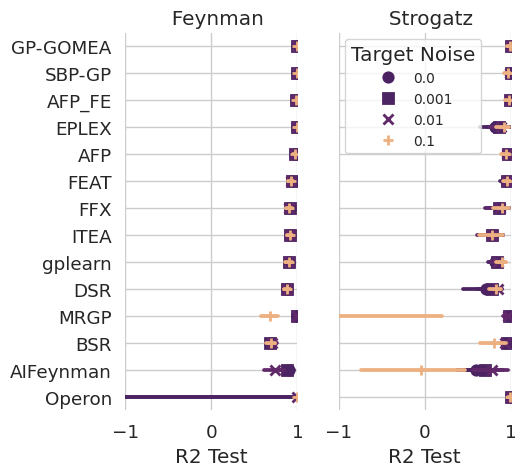

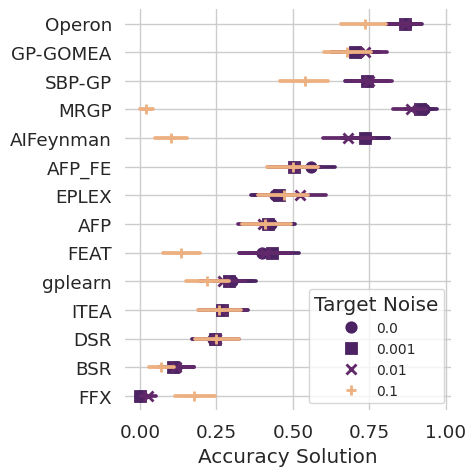

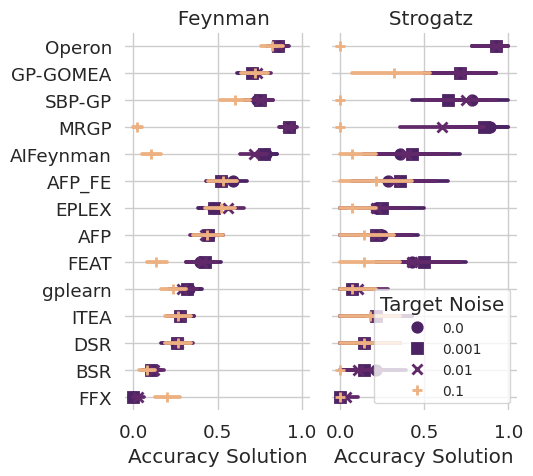

In [ ]:
for metric in ['symbolic_solution_rate_(%)','r2_test','accuracy_solution']:
# for metric in ['r2_test']:
    for kind in ['point']: #,'strip']:
        args =dict(df_compare=df_sum, x=metric, est=np.mean, orient='h',
                   kind=kind)
        if kind=='point':
            args['join'] = False
            args['markers']=['o','s','x','+']
        if metric == 'r2_test':
            args['xlim'] = [-1, 1]
        compare(**args,
                hue='target_noise',
                col=None,
                )
        compare(**args,
                hue='target_noise',
                col='data_group',
                )

saving pairgrid_symbolic_solution_rate_(pct)_r2_test_simplified_complexity.pdf


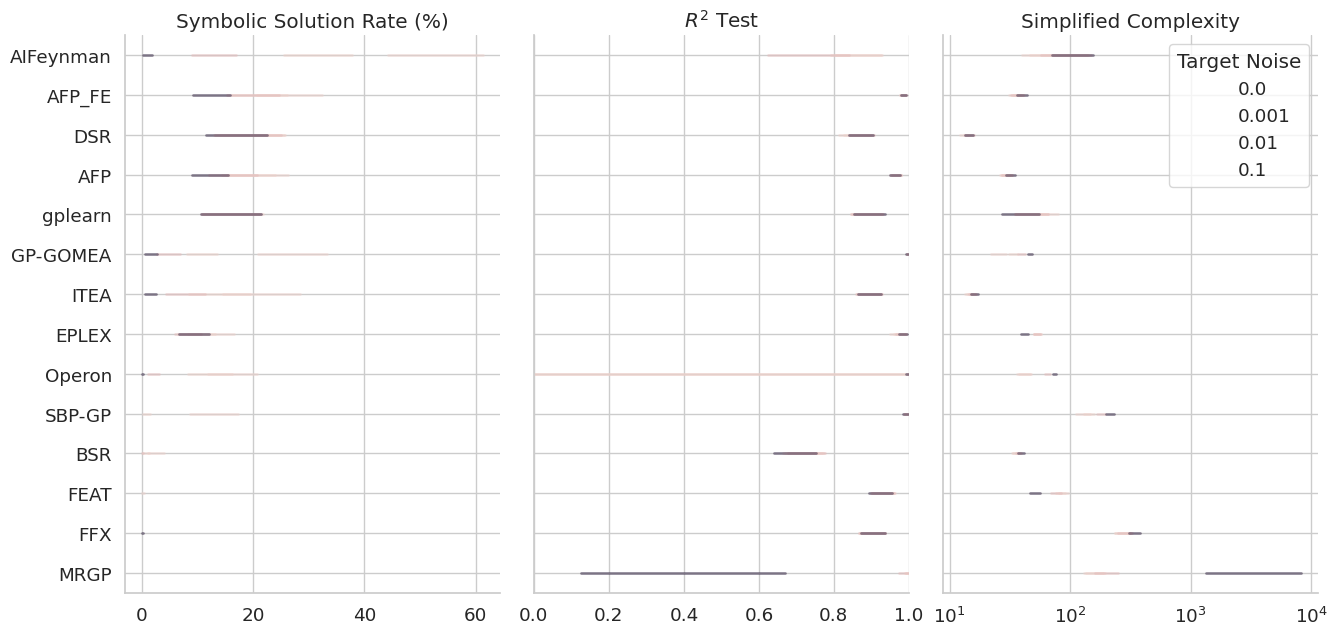

In [10]:
# Make the PairGrid
df_plot = df_sum.copy()
tmp = df_plot.groupby(['target_noise','algorithm'])['symbolic_solution_rate'].mean().unstack().mean()
order = tmp.sort_values(ascending=False).index
df_plot['size_diff'] = df_plot['model_size']-df_plot['simplified_complexity']+1
x_vars=[
#         'accuracy_solution_rate_(%)',
#         'mse_test',
#         'r2_test_rank',
#         'r2_test_norm',
        'symbolic_solution_rate_(%)',
        'r2_test',
        'simplified_complexity',
#         'size_diff',
#         'model_size',
#         'training time (s)',
#         'solution'
]
g = sns.PairGrid(df_plot,
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=6.5,
                 aspect=0.7,
                 hue='target_noise',
#                  hue_order=[0.01,0.001,0]
#                  hue='dataset'
                )
g.map(sns.pointplot,
#       size=10,
      orient="h",
      order=order,
      palette="flare_r",
      err_kws={'linewidth': 2},
      linewidth=0.01,
      markeredgecolor='w',
      linestyle='none',
      estimator=np.mean,
      errorbar=('ci', 95),
      markers=['x','o','s','+'],
      alpha=0.5
     )
plt.legend(title='Target Noise')
titles = [x.replace('_',' ').title().replace('(S)','(s)') for x in x_vars]

for ax, title in zip(g.axes.flat, titles):

    # remove xlabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set a different title for each axes
    ax.set(title=title)

    if any([n in title.lower() for n in ['size','complexity','time']]):
        ax.set_xscale('log')
    if 'R2' in title and 'Rank' not in title:
        ax.set(title=title.replace('R2','$R^2$'))
        ax.set_xlim([0,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)
save(g, 'pairgrid_'+'_'.join(x_vars))